In [1]:
import torch
import os
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from copy import deepcopy
from time import time
import numpy as np
from PIL import Image
from torchvision import models
from tqdm import tqdm
from torch.utils.data.dataset import Dataset

# just to ignore the matplotlib warnings to make the plots look better
import warnings
warnings.filterwarnings('ignore')
# test whether the cuda is available
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(torch.__version__)
print(torch.cuda.is_available())

1.13.0
True


In [2]:
def plot_graph(train_precision, train_recall, train_loss, val_precision, val_recall, val_loss):
    x=range(1,len(train_precision)+1)
    plt.xlabel("iteration")
    plt.plot(x,train_precision,label="train_precision")
    plt.plot(x,train_recall,label="train_recall")
    plt.plot(x,val_precision,label="val_precision")
    plt.plot(x,val_recall,label="val_recall")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    plt.show()

    x=range(1,len(train_loss)+1)
    plt.xlabel("epoch")
    plt.plot(x,train_loss,label="train_loss")
    plt.plot(x,val_loss,label="val_loss")
    plt.legend(loc="lower left")
    plt.show()

In [59]:
import pandas as pd
train_biz=pd.read_csv('./train_photo_to_biz_ids.csv')
train=pd.read_csv('./train.csv')
sub=pd.read_csv('./sample_submission.csv')

In [60]:
# convert string to list of int
train=train.dropna(subset=['labels'])
labels=train['labels'].tolist()
for index,x in enumerate(labels):
     labels[index]= [int(c) for c in str(x).split(' ')]
train['labels'] = labels

In [61]:
# use small data set for development
development_size=0.05
unsued_data,data = train_test_split(train,test_size=development_size, random_state=40)

train_data, test_data = train_test_split(data, test_size=0.1, random_state=40)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=40)


In [62]:
# merging
train_data=pd.merge(train_biz,train_data, on='business_id')
val_data=pd.merge(train_biz,val_data, on='business_id')
test_data=pd.merge(train_biz,test_data, on='business_id')
test_data = test_data.groupby('business_id').agg({'photo_id':lambda x: list(x)}).reset_index()
test_data = pd.merge(train,test_data, on='business_id')

In [7]:
test_data.loc[0]

photo_id             101218
business_id            1688
labels         [1, 3, 6, 8]
Name: 0, dtype: object

In [8]:
# Define dataset class
class Image_Dataset(Dataset):
    def __init__(self, data_path, data, transform=None):
        self.image_id = data['photo_id'].tolist()
        self.labels=data['labels'].tolist()
        self.transform = transform
        self.data_path = data_path
        self.classes = [0,1,2,3,4,5,6,7,8]
        
          
        for index in range(len(self.labels)):
            labels = self.labels[index]
            vector=[0,0,0,0,0,0,0,0,0]
            for i in range(9):
                if i in labels:
                    vector[i] = 1
            self.labels[index] = np.array(vector, dtype=float)

    def __getitem__(self, index):
        label = self.labels[index]
        img_path = os.path.join(self.data_path, str(self.image_id[index])+'.jpg')
        img = Image.open(img_path)
        if self.transform:
            # dont know why all output of the transform are negative
            img = -self.transform(img)
        return img, label
    def __len__(self):
        return len(self.image_id)

class Test_Dataset(Dataset):
    def __init__(self, data_path, data, transform=None):
        self.image_id = data['photo_id'].tolist()
        self.labels=data['labels'].tolist()
        self.transform = transform
        self.data_path = data_path
        self.classes = [0,1,2,3,4,5,6,7,8]


        for index in range(len(self.labels)):
            labels = self.labels[index]
            vector=[0,0,0,0,0,0,0,0,0]
            for i in range(9):
                if i in labels:
                    vector[i] = 1
            self.labels[index] = np.array(vector, dtype=float)

    def __getitem__(self, index):
        label = self.labels[index]
        imgs=[]
        for id in self.image_id[index]:
            img_path = os.path.join(self.data_path, str(id)+'.jpg')
            img = Image.open(img_path)
            if self.transform:
                # dont know why all output of the transform are negative
                img = -self.transform(img)
            imgs.append(img.numpy())
        imgs=torch.tensor(imgs)
        return imgs, label
    def __len__(self):
        return len(self.image_id)
test_dataset = Test_Dataset('./train_photos', test_data, test_transform);
test_dataloader = DataLoader(test_dataset, batch_size=1)


In [9]:
# transformation

mean = [0.485,0.456,0.406]
std = [0.229,0.224,0.225]

train_transform = transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        ])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [10]:
train_dataset = Image_Dataset('./train_photos', train_data, train_transform)
val_dataset = Image_Dataset('./train_photos', val_data, test_transform)

In [47]:
# this part can be tuned
class Resnext50(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.regnet_x_800mf(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features,out_features=9),
        )
        self.model = resnet
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.model(x))

In [12]:
# this part can be tuned

device = torch.device('cuda')






In [13]:


def training(model, optimizer,  device,loss_func, l2_lambda, train_dataloader, val_dataloader,epoch ):
    train_precision = []
    train_recall=[]
    train_loss = []

    val_precision = []
    val_recall=[]
    val_loss = []
    best_f1 = 0
    best_model = None
    best_i = 0

    
    model = model.to(device)
    
    for i in range(epoch):
        model.train()
        
        train_batch_precision=[]
        train_batch_recall=[]
        train_batch_loss =[]
        num = 0
        for images, labels in tqdm(train_dataloader):
            num+=1
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_func(output, labels.type(torch.float))
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                pred = (output>0.5).cpu()
                labels = labels.cpu()
                train_batch_precision.append(precision_score(labels, pred,average='micro'))
                train_batch_recall.append(recall_score(labels, pred,average='micro'))
                train_batch_loss.append(loss.cpu().detach())


        torch.cuda.empty_cache()
        train_precision.append(np.array(train_batch_precision).mean())
        train_recall.append(np.array(train_batch_recall).mean())
        train_loss.append(np.array(train_batch_loss).mean())

        val_batch_precision=[]
        val_batch_recall=[]
        val_batch_loss=[]


        # validation
        model.eval()
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)

                loss = loss_func(output, labels.type(torch.float))
                l2_lambda = 0.001
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss = loss + l2_lambda * l2_norm

                pred = np.array(np.array(output.cpu()) >0.5, dtype=float)
                labels = labels.cpu()

                val_batch_precision.append(precision_score(labels,pred,average='micro'))
                val_batch_recall.append(recall_score(labels,pred,average='micro'))
                val_batch_loss.append(loss.cpu().detach())

            precision = np.array(val_batch_precision).mean()
            recall = np.array(val_batch_recall).mean()
            loss = np.array(val_batch_loss).mean()

            val_precision.append(precision)
            val_recall.append(recall)
            val_loss.append(loss)

            f1 = 2 * (precision * recall) / (precision + recall)

            if  f1> best_f1:
                best_f1 = f1
                best_model = deepcopy(model.state_dict())
                best_i = i
        

        print("train_precision:{:.4f}, train_recall:{:.4f}, train_loss:{:.4f}".format(train_precision[-1],train_recall[-1],train_loss[-1]))
        print('val_precision:{:.4f}, val_recall:{:.4f}, val_loss:{:.4f}'.format( val_precision[-1],val_recall[-1],val_loss[-1]))

    print('best epoch {}, train precision {:.4f} val precision {:.4f}, f1 {:.4f}'.format(best_i, train_precision[best_i], val_precision[best_i], best_f1))
    model.load_state_dict(best_model)
    return train_precision, train_recall, train_loss, val_precision, val_recall, val_loss

In [48]:
# Training
model = Resnext50()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_func = nn.BCELoss()
l2_lambda=5e-3
epoch = 5
train_dataloader = DataLoader(train_dataset, batch_size=48,  shuffle=True,drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
torch.cuda.empty_cache()
train_precision, train_recall, train_loss, val_precision, val_recall, val_loss = training(model,optimizer,device,loss_func,l2_lambda,train_dataloader,val_dataloader,epoch)


Downloading: "https://download.pytorch.org/models/regnet_x_800mf-ad17e45c.pth" to C:\Users\flssh/.cache\torch\hub\checkpoints\regnet_x_800mf-ad17e45c.pth


  0%|          | 0.00/27.9M [00:00<?, ?B/s]

100%|██████████| 164/164 [01:40<00:00,  1.63it/s]


train_precision:0.6820, train_recall:0.7263, train_loss:72.3931
val_precision:0.6314, val_recall:0.6875, val_loss:14.7132


100%|██████████| 164/164 [01:37<00:00,  1.67it/s]


train_precision:0.7165, train_recall:0.7604, train_loss:14.6388
val_precision:0.6477, val_recall:0.7560, val_loss:14.5806


100%|██████████| 164/164 [01:37<00:00,  1.68it/s]


train_precision:0.7436, train_recall:0.7745, train_loss:14.5079
val_precision:0.6751, val_recall:0.7970, val_loss:14.4515


100%|██████████| 164/164 [01:44<00:00,  1.58it/s]


train_precision:0.7698, train_recall:0.7819, train_loss:14.3873
val_precision:0.6889, val_recall:0.7974, val_loss:14.3374


100%|██████████| 164/164 [01:39<00:00,  1.64it/s]


train_precision:0.7858, train_recall:0.7860, train_loss:14.2750
val_precision:0.6901, val_recall:0.8012, val_loss:14.2358
best epoch 4, train precision 0.7858 val precision 0.6901, f1 0.7415


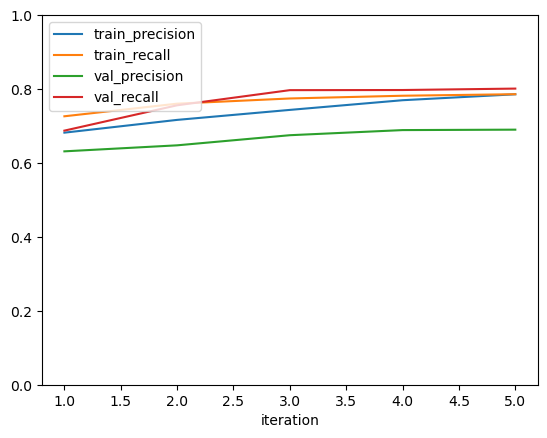

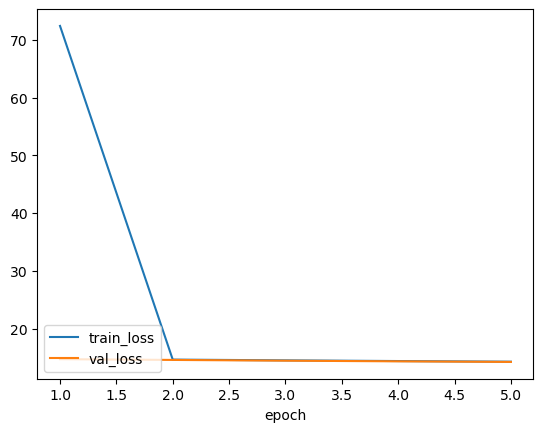

In [49]:
plot_graph(train_precision, train_recall, train_loss, val_precision, val_recall, val_loss)

In [15]:
# Save model
PATH="./models/best_model.pt"
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), PATH)

In [14]:
# load best_model
PATH="./models/best_model.pt"
model=Resnext50()
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()


Resnext50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [65]:
# evaluation on test set
torch.cuda.empty_cache()
model.to(device)
model.eval()
single_precision=[]
single_recall=[]
average_precision=[]
average_recall=[]
for imgs,labels in tqdm(test_dataloader):
    with torch.no_grad():
        imgs=imgs[0].to(device)
        output = model(imgs)
        labels=labels.numpy()
        pred = np.array(np.array(output.cpu()) >0.5, dtype=float)
        single_precision.append(precision_score(np.resize(labels,(pred.shape[0],9)),pred,average='micro'))
        single_recall.append(recall_score(np.resize(labels,(pred.shape[0],9)),pred,average='micro'))

        average_output=output.mean(dim=0)
        pred = np.array(np.array(average_output.cpu()) >0.5, dtype=float)
        average_precision.append(precision_score(labels[0],pred,average='micro'))
        average_recall.append(recall_score(labels[0],pred,average='micro'))

single_precision = sum(single_precision) / len(single_precision)
single_recall = sum(single_recall) / len(single_recall)
f1 = 2 * (single_precision * single_recall) / (single_precision + single_recall)
print("single imgae f1: "+str(f1))

average_precision = sum(average_precision) / len(average_precision)
average_recall = sum(average_recall) / len(average_recall)
f1 = 2 * (average_precision * average_recall) / (average_precision + average_recall)
print("average imgae f1: "+str(f1))

100%|██████████| 10/10 [01:14<00:00,  7.43s/it]

single imgae f1: 0.6161713390431492
average imgae f1: 0.6555555555555554


In [58]:
label_notation = {0: 'good_for_lunch', 1: 'good_for_dinner', 2: 'takes_reservations',  3: 'outdoor_seating',
                  4: 'restaurant_is_expensive', 5: 'has_alcohol', 6: 'has_table_service', 7: 'ambience_is_classy',
                  8: 'good_for_kids'}
def test(index):
    test_dataset = Test_Dataset('./train_photos', test_data.loc[[index]], test_transform);
    test_dataloader = DataLoader(test_dataset, batch_size=1)
    for imgs,labels in test_dataloader:
        imgs=imgs[0].to(device)
        with torch.no_grad():
            pred = model(imgs)
            pred=pred.mean(dim=0)
            pred = np.array(np.array(pred.cpu()) >0.5, dtype=float)
        predicted_labels = np.array(val_dataset.classes)[np.argwhere(pred > 0)[:, 0]]
        true_labels = np.array(val_dataset.classes)[np.argwhere(np.array(labels[0]) > 0)[:, 0]]

        result = [label_notation[p] for p in predicted_labels]
        expected = [label_notation[p] for p in true_labels]
        print("business_id: " + str(test_data.loc[index]['business_id']))
        print("ground_true: ",expected)
        print("prediction: ",result)

        ids = test_data.loc[index]['photo_id']
        print("Show 1 image out of "+str(len(ids)))
        id=ids[0]
        path = os.path.join("./train_photos", str(id)+'.jpg')
        plt.imshow(Image.open(path))
        plt.axis('off')
        plt.show()
test(0)

FileNotFoundError: [Errno 2] No such file or directory: './train_photos\\[[101218, 196237, 321136, 395219, 132538, 235949, 252427, 228860, 445148, 246539, 115506, 351133, 68846, 80873, 262987, 302956, 31829, 309234, 353587, 93673, 441669, 188209, 440799, 354528, 77978, 196675, 246830, 396155, 262503, 468372, 314399, 101732, 438338, 323715, 228107, 248484, 318718, 43660, 388105, 226954, 277974, 403507, 29697, 119678, 292645, 270508, 418426, 156726, 220462, 24637, 113027, 155042, 112745, 322102, 302783, 412715, 197026, 393542, 178389, 53090, 195671, 328543, 64859, 251700, 155578, 8713, 60245, 257498, 51404, 412422, 220067, 243961, 326866, 252112, 194259, 365694, 258517, 31254, 284186, 243140, 84877, 437712, 258079, 65740, 366913, 336555, 100407, 246256, 108267, 383048, 95112, 224602, 267905, 367555, 183932, 193192, 294535, 252569, 156964, 204735, 213599, 168414, 169118, 15656, 288929, 402281, 315675, 392464, 97694, 15332, 142527, 72584, 431834, 463108, 274494, 108234, 218304, 158815, 143802, 61310, 107620, 360815, 357687, 377993, 138493, 408216, 285270, 192196, 304174, 442170, 116520, 268552, 50539, 258650, 229420, 135794, 314283, 41620, 111591, 104332, 160770, 334325, 260783, 229353, 380329, 106359, 334735, 385308, 131225, 333269, 308731, 278360, 398269, 35715, 217206, 111458, 446438, 250182, 87829, 178217, 310774, 342081, 290382, 266640, 207874, 288608, 117517, 22417, 318456, 140408, 452880, 92015, 381436, 166134, 50108, 445367, 72747, 282417, 458027, 449733, 211252, 40718, 136739, 333055, 414056, 250877, 251560, 407203, 93587, 421455, 119987, 209395, 157687, 96567, 366700, 194164, 292323, 319393, 278884, 471693, 135425, 160081, 286972, 168148, 274089, 411900, 392472, 444747, 213959, 136973, 115669, 285824, 29768, 51648, 87123, 41951, 324166, 402527, 369406, 283969, 227973, 275208, 228411, 370651, 361148, 333101, 259604, 107965, 330365, 9068, 208424, 424644, 351785, 386973, 218801, 259521, 201349, 348272, 287400, 132739, 242767, 193100, 398854, 227329, 345567, 154837, 338964, 3620, 128837, 66124, 75938, 130467, 101677, 213937, 340372, 89711, 443691, 40805, 264350, 176180, 277001, 43490, 27059, 138785, 33119, 262655, 236835, 280108, 329850, 224782, 289571, 157791, 161773, 88435, 178097, 456272, 449330, 203892, 457993, 147212, 51182, 406199, 297070, 112540, 203173, 127465, 182041, 364486, 39294, 145171, 106490, 341270, 234944, 74140, 53699, 126595, 90533, 168715, 365842, 381802, 22559, 67387, 176107, 73515, 251281, 240957, 234892, 2535, 310336, 426555, 406734, 31626, 257011, 61909, 41914, 122399, 188319, 284620, 22927, 248177, 158896, 308261, 59498, 458557, 299599, 83720, 269448, 353043, 233078, 70254, 223670, 191666, 99721, 43125, 74766, 90193, 343992, 12175, 201430, 402047, 23827, 224379, 200744, 270618, 339274, 471012, 270040, 67540, 467270, 270095, 90792, 297445, 130004, 361520, 90769, 390650, 92359, 35900, 96966, 241593, 275733, 173388, 144785, 367606, 464288, 329298, 14222, 123285, 284598, 191376, 253378, 361513, 79157, 385842, 207052, 304130, 348945, 253973, 233191, 409432, 18980]].jpg'